In [6]:
if (!require(rvest)) install.packages('rvest')
library(rvest)

if (!require(tidyverse)) install.packages('tidyverse')
library(tidyverse)

target_url <- 'https://ko.wikipedia.org/wiki/%EC%A1%B0%EC%84%A0_%EA%B5%AD%EC%99%95'
html <- read_html(target_url)

# 왕의 대수를 입력하면 왕의 정보를 반환하는 함수를 정의함
get_king_info <- function(order){
    tables <- html %>%
        html_nodes('table[class=wikitable]') %>%
        html_nodes('tr') %>%    
        html_text()
    
    tables <- gsub('\n', '', tables) # \n을 삭제한다.
    tables <- tables[grep('^제', tables)][order] # 왕별 데이터는 '제'로 스타트

    sep_tables <- tables %>% # 한글자씩 쪼갠다.
        strsplit(split = '') %>%
        unlist()

    # 한자는 사용하지 않는다.
    # 따라서 편의를 위해 한글과 숫자가 아닌 문자는 모두 N으로 치환한다.
    sep_tables[-grep('[ㄱ-ㅎ|가-힣|0-9|]', sep_tables)] = 'N'
    
    order <-
        sep_tables[grep('제', sep_tables)[1] : grep('대', sep_tables)[1]] %>%
        paste(collapse = '')
    
    # order와 name은 연결되어 있다. ex) 제10대연산군
    # 왕의 이름은 조,종,군 중 하나로 끝난다.
    name <- 
        sep_tables[(grep('대', sep_tables)[1]+1): grep('조|종|군', sep_tables)[1]] %>%
        paste(collapse = '')
    
    years <- c()
    for (i in grep('년', sep_tables)){
        years <- c(years, paste0(sep_tables[(i-3):i-1], collapse = ''))
    }
    birth <- years[1]
    death <- years[2]
    king_start <- years[3]
    king_end <- years[4]
    
    pasted <- unlist(strsplit(paste0(sep_tables, collapse = ''), split = 'N'))
    grave <- pasted[grep('릉|묘$', pasted)] # 왕의 무덤은 릉, 묘로 끝난다.
    
    return(c(order, name, birth, death, king_start, king_end, grave))
}

kings <- vector('list', 26)
for (i in 1:length(kings)){
    kings[[i]] <- get_king_info(i)
}
final <- do.call('rbind', kings)
colnames(final) <- c('order', 'name', 'birth', 'death', 'king_start', 'king_end', 'grave')
write.table(final, 'Joseon_king.txt', row.names=FALSE)

필요한 패키지를 로딩중입니다: tidyverse

Warning message:
"패키지 'tidyverse'는 R 버전 4.1.3에서 작성되었습니다"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

Warning message:
"패키지 'ggplot2'는 R 버전 4.1.3에서 작성되었습니다"
Warning message:
"패키지 'tibble'는 R 버전 4.1.3에서 작성되었습니다"
Warning message:
"패키지 'tidyr'는 R 버전 4.1.3에서 작성되었습니다"
Warning message:
"패키지 'readr'는 R 버전 4.1.3에서 작성되었습니다"
Warning message:
"패키지 'purrr'는 R 버전 4.1.3에서 작성되었습니다"
Warning message:
"패키지 'dplyr'는 R 버전 4.1.3에서 작성되었습니다"
Warning message:
"패키지 'stringr'는 R 버전 4.1.3에서 작성되었습니다"
Warning message:
"패키지 'forcats'는 R 버전 4.1.3에서 작성되었습니다"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter()         masks stats::filter()
x readr::guess_encoding() masks rvest::guess_enc

In [4]:
data <- data.frame(final)
head(data)

,order,name,birth,death,king_start,king_end,grave
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,제1대,태조,1335,1408,1392,1398,건원릉
2,제2대,정종,1357,1419,1398,1400,후릉
3,제3대,태종,1367,1422,1400,1418,헌릉
4,제4대,세종,1397,1450,1418,1450,영릉
5,제5대,문종,1414,1452,1450,1452,현릉
6,제6대,단종,1441,1457,1452,1455,장릉


In [39]:
data[,'birth'] <- as.numeric(data[,'birth'])
data[,'death'] <- as.numeric(data[,'death'])
data[,'king_start'] <- as.numeric(data[,'king_start'])
data[,'king_end'] <- as.numeric(data[,'king_end'])

data <- data %>% mutate(age = death - birth)

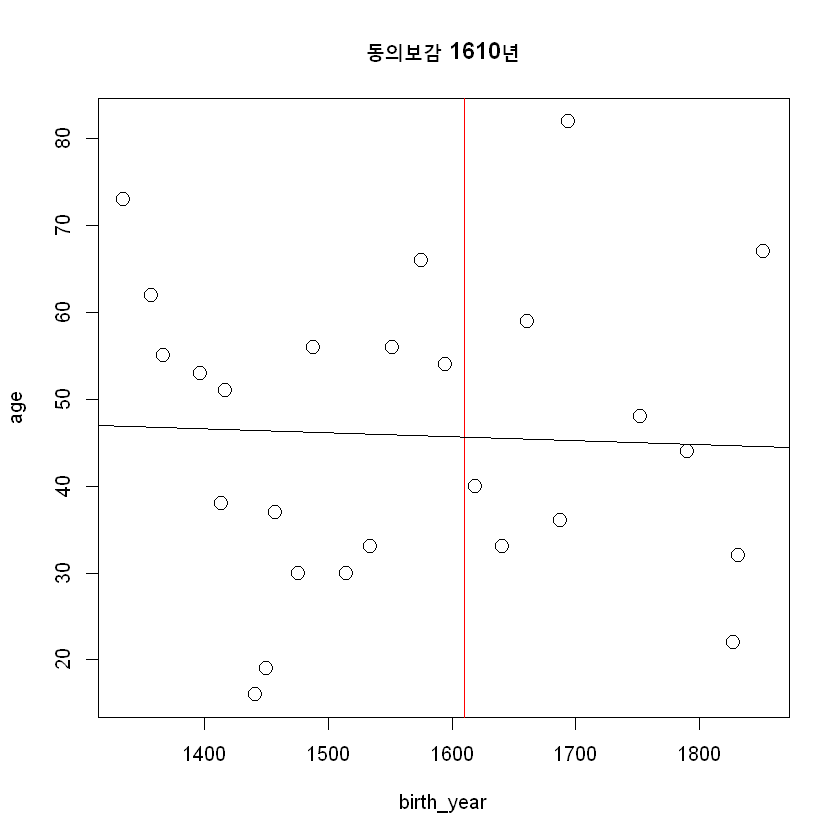

In [49]:
plot(data[,'birth'], data[,'age'],
     xlab = 'birth_year', 
     ylab = 'age',
     main = '동의보감 1610년',
     cex = 1.5)
abline(v = 1610, col = 'red')
abline(lm(age ~ birth, data = data))

In [ ]:
fact <- 

In [60]:
Before <- data[data[,'birth'] <= 1610, 'age']
After <- data[data[,'birth'] > 1610, 'age']

In [66]:
After

[1] 40 33 59 36 82 48 44 22 32 67

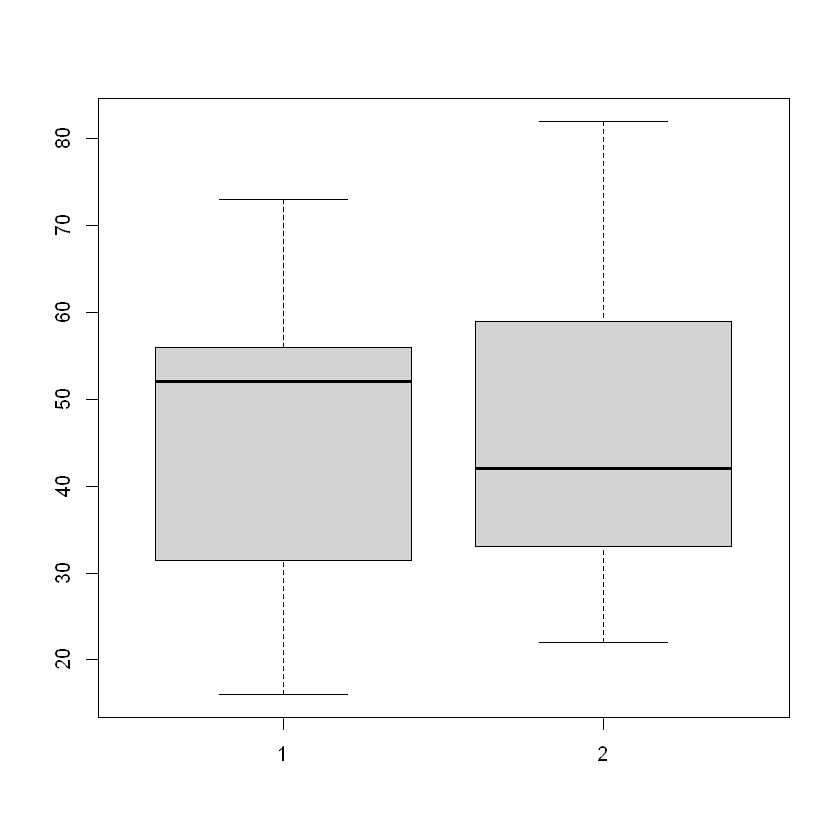

In [65]:
boxplot(Before, After)

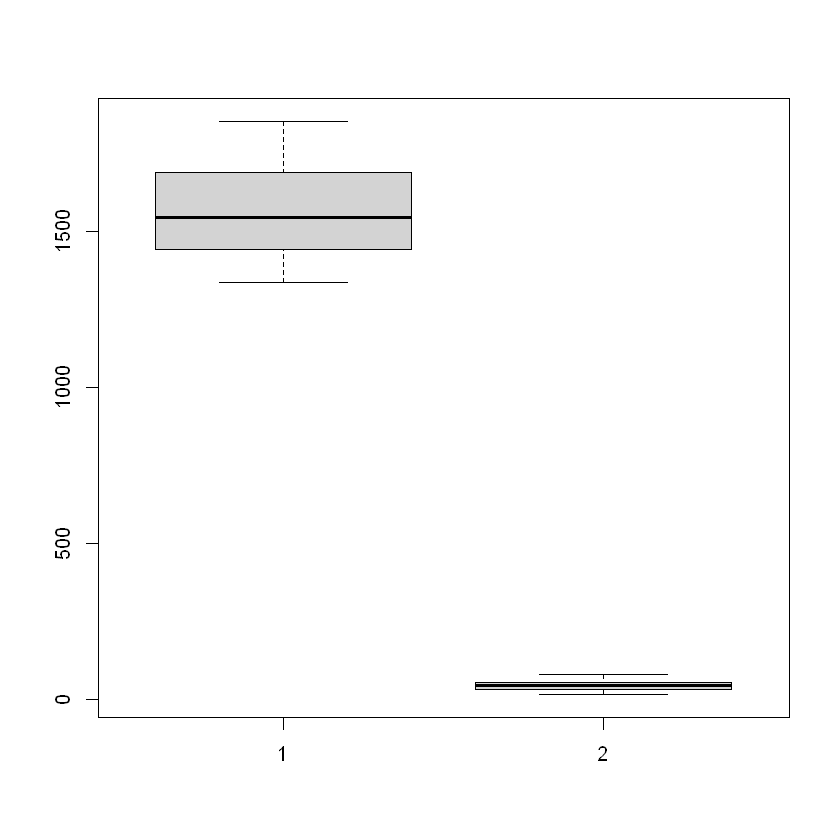

In [51]:
boxplot(data[,'birth'], data[,'age'])

In [27]:
data['birth'][,]

[1] 1335 1357 1367 1397 1414 1441 1417 1450 1457 1476 1488 1515 1534 1552 1575
[16] 1595 1619 1641 1661 1688 1694 1752 1790 1827 1831 1852